# Creating our First Models

This notebook will detail creating our first machine learning models we will show how to create the models using Sci-Kit Learn and TensorFlow.  The models we will show are:
- Decision Tree
- Random Forest
- Support Vector Machine
- Neural Network (Fully Connected)

In [19]:
import pandas as pd
import sklearn.datasets
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from os.path import join

# This setting makes sure that when training
# TensorFlow models it will not automatically 
# use all of the available RAM on the GPU,
# which it will do otherwise.

from os import environ
environ['TF_FORCE_GPU_ALLOW_GROWTH'] = "true"

import os
import sys
module_path = os.path.abspath(os.path.join(".."))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from utils import hello_world
hello_world()

# Loading From Google Drive

When using Google Colab, you can load data from Google Drive,
the following code will allow us to either load from Google Drive
or to load from our local filesystem, depending on how we are 
running our system.

In [115]:
try:
    from google.colab import drive
    drive.mount('/content/drive')
    base_location = "/content/drive/My Drive/data/"
except:
    base_location = "/home/capcolabs/data/FannieMae/"

In [116]:
!ls /home/capcolabs/data/FannieMae

2000Q1	Acquisition_All  Performance_All.zip
2010Q1	Performance_All  Performances


In [117]:
!ls /content/drive/My\ Drive/data/2010Q1

ls: cannot access '/content/drive/My Drive/data/2010Q1': No such file or directory


# Financial Datasets

There are a large number of financial datasets that are available, the first one we will discuss is the Fannie Mae Fixed Rate Mortgage Dataset.

- https://www.fanniemae.com/portal/funding-the-market/data/loan-performance-data.html

- https://loanperformancedata.fanniemae.com/lppub/index.html#Portfolio

Which consists of both Acquisitions and Performance data for a collection of mortgages.

To make our lives a bit easier here are the column names pulled from the provided `R` script to load the data.  See `R` is good for at least one thing.

In [118]:
AcquisitionColumnNames = (
    "LOAN_ID", "ORIG_CHN", "Seller.Name", 
    "ORIG_RT", "ORIG_AMT", "ORIG_TRM", "ORIG_DTE",
    "FRST_DTE", "OLTV", "OCLTV", "NUM_BO", 
    "DTI", "CSCORE_B", "FTHB_FLG", "PURPOSE", 
    "PROP_TYP", "NUM_UNIT", "OCC_STAT", "STATE", "ZIP_3", 
    "MI_PCT", "Product.Type", "CSCORE_C", "MI_TYPE", 
    "RELOCATION_FLG"
)

PerformanceColumnNames = (
    "LOAN_ID", "Monthly.Rpt.Prd", "Servicer.Name", 
    "LAST_RT", "LAST_UPB", "Loan.Age", "Months.To.Legal.Mat", 
    "Adj.Month.To.Mat", "Maturity.Date", "MSA", 
    "Delq.Status", "MOD_FLAG", "Zero.Bal.Code", 
    "ZB_DTE", "LPI_DTE", "FCC_DTE","DISP_DT", 
    "FCC_COST", "PP_COST", "AR_COST", "IE_COST", 
    "TAX_COST", "NS_PROCS","CE_PROCS", "RMW_PROCS", 
    "O_PROCS", "NON_INT_UPB", "PRIN_FORG_UPB_FHFA", 
    "REPCH_FLAG", "PRIN_FORG_UPB_OTH", "TRANSFER_FLG"
)

In [119]:
# Data path will change depending on your system setup.

acquisition_data_path = join(base_location, "2010Q1/Acquisition_2010Q1.txt")
# f"{base_location}2010Q1/Acquisition_2010Q1.txt"

#### Loading the Acquisition Data from CSV

To load the data we call from `pandas`, `pd.read_csv` which automatically handles loading data from the csv file.  We provide column names, a notification that the file doesn't include headers, and information on what the column separator is `|` in this case.

In [120]:
acquisition_df = pd.read_csv(
    acquisition_data_path,
    names=AcquisitionColumnNames,
    header=None,
    sep="|"
)

In [23]:
acquisition_df.columns

Index(['LOAN_ID', 'ORIG_CHN', 'Seller.Name', 'ORIG_RT', 'ORIG_AMT', 'ORIG_TRM',
       'ORIG_DTE', 'FRST_DTE', 'OLTV', 'OCLTV', 'NUM_BO', 'DTI', 'CSCORE_B',
       'FTHB_FLG', 'PURPOSE', 'PROP_TYP', 'NUM_UNIT', 'OCC_STAT', 'STATE',
       'ZIP_3', 'MI_PCT', 'Product.Type', 'CSCORE_C', 'MI_TYPE',
       'RELOCATION_FLG'],
      dtype='object')

#### Loading the Performance Data

In [25]:
performance_data_path = join(base_location, "2010Q1/Performance_2010Q1.txt") #
# f"{base_location}2010Q1/Performance_2010Q1.txt"


performance_df = pd.read_csv(
    performance_data_path,
    names=PerformanceColumnNames,
    header=None,
    sep="|"
)


First thing we note is that this takes longer than the `Acquisitions` data to load, stemming from the fact that for each loan there are multiple monthly data elements loaded.

# Data Modifying

In [26]:
DS = set(performance_df['Delq.Status'])

In [27]:
print(DS)
mapper = {}
for ds in DS:
    try:
        mapper[ds] = int(ds)
    except:
        mapper[ds] = -1

performance_df['Delq.Status'] = performance_df['Delq.Status'].map(mapper)

{nan, '96', '40', '70', '48', '56', '94', '91', '33', '24', '17', '18', '83', '98', '2', '43', '93', '71', '54', '46', '20', '61', '4', '29', '76', '47', '75', '39', '99', '8', '3', '11', '26', '52', '72', '89', '27', '28', '49', '21', '41', '87', '86', '38', '63', '44', '85', '0', '32', '31', '14', '57', '50', '92', '25', '90', '80', '95', '34', '81', '78', '7', '12', '10', '65', '58', '66', '55', '97', '45', '59', '13', '22', '35', '37', '73', '74', '79', '1', '42', '67', '60', '9', '51', 'X', '23', '77', '69', '5', '36', '15', '16', '19', '62', '84', '82', '88', '6', '53', '30', '68', '64'}


In [28]:
V, C = np.unique(performance_df['Delq.Status'], return_counts=True)
print(V)

[-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22
 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46
 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70
 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94
 95 96 97 98 99]


# Grouping By Loan ID

https://stackoverflow.com/questions/15705630/get-the-rows-which-have-the-max-value-in-groups-using-groupby

In [29]:
loans = performance_df.groupby("LOAN_ID", sort=True)['Delq.Status'].max()

ID_To_Delinq = {}

for row in loans.iteritems():
    loan_id, delinq = row
    ID_To_Delinq[loan_id] = delinq

In [30]:
def mapper(row):
    return ID_To_Delinq.get(row["LOAN_ID"], -1)

acquisition_df['MAX_DELINQ'] = acquisition_df.apply(mapper, axis=1)

In [31]:
V, C = np.unique(acquisition_df['MAX_DELINQ'], return_counts=True)

# Data Loading For Model

We first need to clean the data and separate into training and testing datasets.

In [32]:
DEL_NOTNAN = acquisition_df["MAX_DELINQ"].notna()
df = acquisition_df[DEL_NOTNAN]

DEL_NOTNEG = df['MAX_DELINQ'] >= 0

df = df[DEL_NOTNEG]
OLTV = df['OLTV'].notna()
df = df[OLTV]
CS = df['CSCORE_B'].notna()
df = df[CS]

credit_score  = np.array(df['CSCORE_B'])
loan_to_value = np.array(df['OLTV'])
max_delinq    = np.array(df['MAX_DELINQ'])

X = np.array([credit_score, loan_to_value]).transpose()
y = np.array([max_delinq]).transpose()
print(X.shape)
print(y.shape)

Total = np.hstack([X, y])
print(Total.shape)
np.random.shuffle(Total)

X = Total[:, :2]
y = Total[:, 2:]

print(X.shape)
print(y.shape)

prop = 0.8
train_num = int(prop * len(Total))
print(f"Train Number: {train_num}")

X_train, X_test = X[:train_num], X[train_num:]
y_train, y_test = y[:train_num], y[train_num:]

print(f"X_Train: {X_train.shape}")
print(f"X_Test: {X_test.shape}")
print("=="*10)
print(f"y_Train: {y_train.shape}")
print(f"y_Test:  {y_test.shape}")

class_names = np.unique(y)

(322866, 2)
(322866, 1)
(322866, 3)
(322866, 2)
(322866, 1)
Train Number: 258292
X_Train: (258292, 2)
X_Test: (64574, 2)
y_Train: (258292, 1)
y_Test:  (64574, 1)


# Decision Tree

- https://towardsdatascience.com/what-is-a-decision-tree-22975f00f3e1

- https://towardsdatascience.com/decision-trees-in-machine-learning-641b9c4e8052


Taken From: https://scikit-learn.org/stable/modules/tree.html#decision-trees

>Decision Trees (DTs) are a non-parametric supervised learning method used for classification and regression. The goal is to create a model that predicts the value of a target variable by learning simple decision rules inferred from the data features.

>Some advantages of decision trees are:

>- Simple to understand and to interpret. Trees can be visualised.
>- Requires little data preparation. Other techniques often require data normalisation, dummy variables need to be created and blank values to be removed. Note however that this module does not support missing values.
>- The cost of using the tree (i.e., predicting data) is logarithmic in the number of data points used to train the tree.
>- Able to handle both numerical and categorical data. Other techniques are usually specialised in analysing datasets that have only one type of variable. See algorithms for more information.
>- Able to handle multi-output problems.
>- Uses a white box model. If a given situation is observable in a model, the explanation for the condition is easily explained by boolean logic. By contrast, in a black box model (e.g., in an artificial neural network), results may be more difficult to interpret.
>- Possible to validate a model using statistical tests. That makes it possible to account for the reliability of the model.
>- Performs well even if its assumptions are somewhat violated by the true model from which the data were generated.

>The disadvantages of decision trees include:

>- Decision-tree learners can create over-complex trees that do not generalise the data well. This is called overfitting. Mechanisms such as pruning (not currently supported), setting the minimum number of samples required at a leaf node or setting the maximum depth of the tree are necessary to avoid this problem.
>- Decision trees can be unstable because small variations in the data might result in a completely different tree being generated. This problem is mitigated by using decision trees within an ensemble.
>- The problem of learning an optimal decision tree is known to be NP-complete under several aspects of optimality and even for simple concepts. Consequently, practical decision-tree learning algorithms are based on heuristic algorithms such as the greedy algorithm where locally optimal decisions are made at each node. Such algorithms cannot guarantee to return the globally optimal decision tree. This can be mitigated by training multiple trees in an ensemble learner, where the features and samples are randomly sampled with replacement.
>- There are concepts that are hard to learn because decision trees do not express them easily, such as XOR, parity or multiplexer problems.
>- Decision tree learners create biased trees if some classes dominate. It is therefore recommended to balance the dataset prior to fitting with the decision tree.



In [33]:
from sklearn import tree

clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)
print(clf.score(X_test, y_test))

0.9056586242140799


### Feature Importance

One useful aspect of tree based methods vs neural networks is we can calculate the importance of each feature in making decisions.  We will call it below, and the documentation is listed at: https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn-tree-decisiontreeclassifier

In [39]:
clf.feature_importances_

array([0.64171836, 0.35828164])

We see that our first feature `credit_score` holds the most weight for making a decision as to it's delinquency, which fits with expectations.

### Testing Parameters of Decision Tree Classifier


In [40]:
dtc = tree.DecisionTreeClassifier(
    max_depth=3,
    class_weight=None
)
dtc.fit(X_train, y_train)
print(dtc.score(X_test, y_test))

0.9094372348003841


# Visualizing the Decision Tree

- https://medium.com/@rnbrown/creating-and-visualizing-decision-trees-with-python-f8e8fa394176

- https://towardsdatascience.com/interactive-visualization-of-decision-trees-with-jupyter-widgets-ca15dd312084

In [41]:
from sklearn.externals.six import StringIO
from sklearn import tree
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

[Text(167.4, 190.26, 'X[0] <= 722.5\ngini = 0.167\nsamples = 258292\nvalue = [235138, 16356, 1848, 740, 533, 577, 443, 375, 290\n221, 196, 161, 139, 127, 112, 122, 85, 90, 62, 65\n48, 50, 42, 47, 34, 39, 27, 31, 32, 11, 21, 18\n19, 16, 13, 17, 10, 7, 6, 13, 6, 7, 7, 9, 4\n4, 3, 6, 6, 3, 4, 6, 1, 2, 3, 4, 3, 1, 2\n4, 1, 4, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1\n1, 2, 1, 1, 1, 1, 1]'),
 Text(83.7, 135.9, 'X[0] <= 668.5\ngini = 0.359\nsamples = 47254\nvalue = [37289, 6220, 1004, 398, 301, 333, 257, 209, 152, 117\n110, 97, 71, 72, 69, 66, 46, 42, 34, 38, 25, 26\n23, 22, 13, 28, 15, 20, 15, 3, 11, 11, 14, 8\n5, 9, 5, 5, 3, 10, 2, 5, 3, 4, 2, 0, 2, 2\n3, 2, 3, 1, 1, 0, 2, 3, 1, 0, 2, 2, 0, 3\n2, 1, 1, 2, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1\n0, 1, 1, 1]'),
 Text(41.85, 81.53999999999999, 'X[0] <= 642.5\ngini = 0.534\nsamples = 9030\nvalue = [5888, 1771, 369, 145, 107, 134, 95, 82, 46, 47, 41\n33, 22, 21, 21, 19, 17, 13, 10, 17, 10, 11, 9\n10, 8, 13, 7, 6, 4, 1, 3, 2, 6, 2, 2, 4, 2\n3, 2, 4, 1, 2, 2, 1, 2,

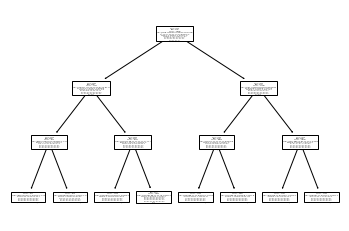

In [42]:
tree.plot_tree(dtc)

Creating Dot Data
Running Export Graphviz
Creating PyDotPlus Graph
Creating Image


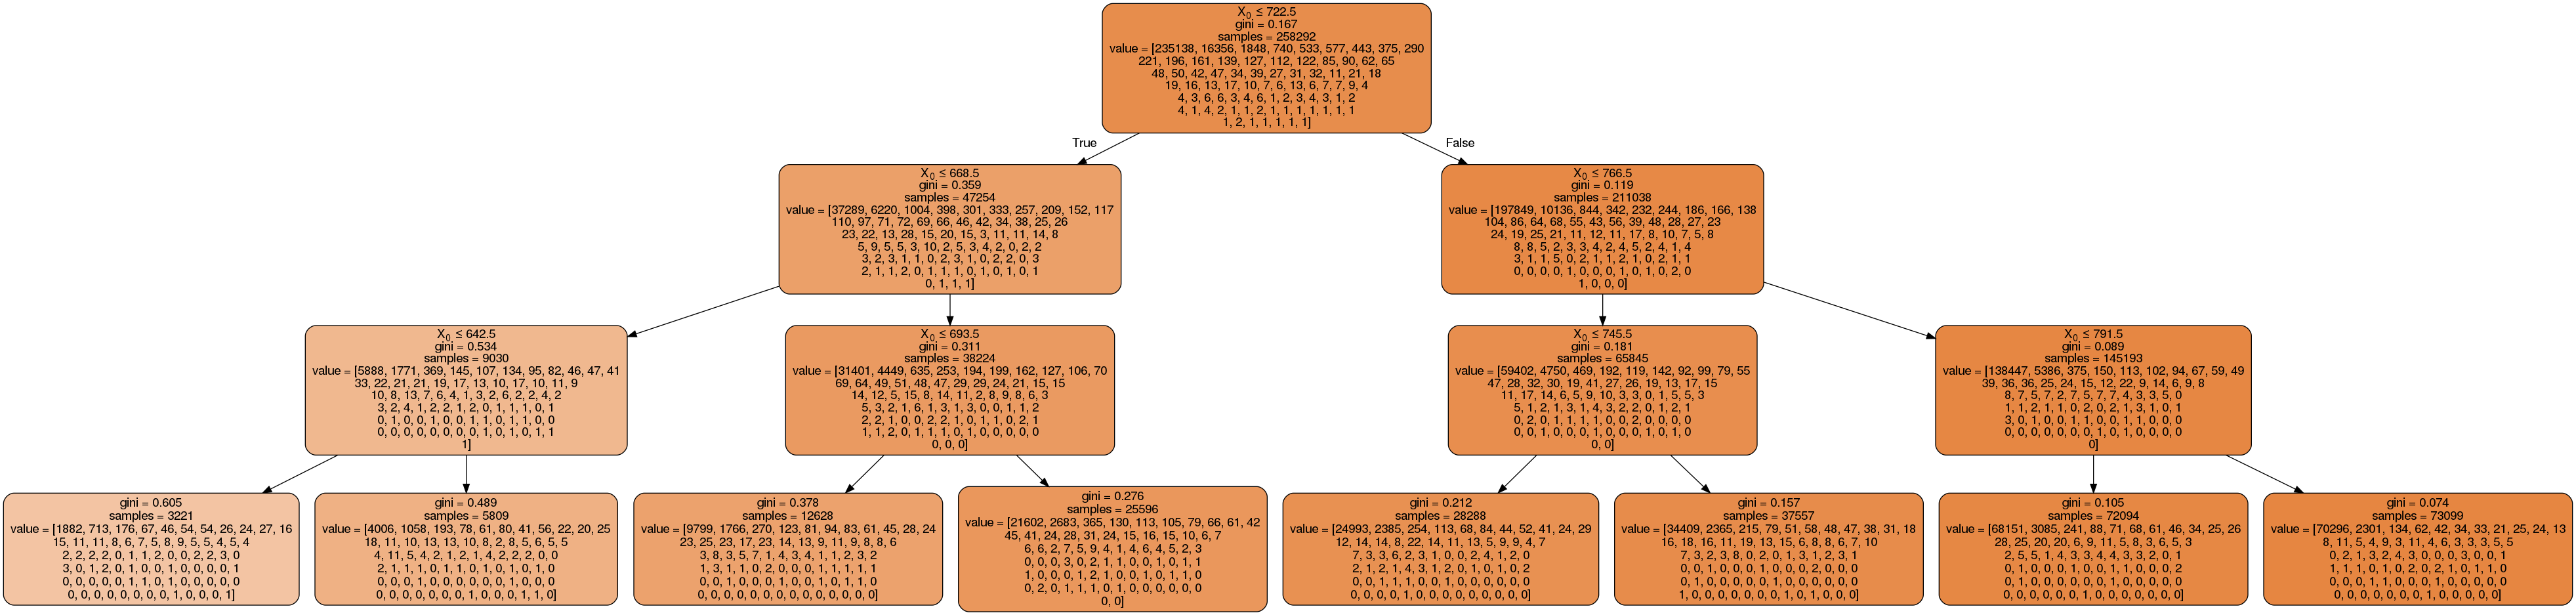

In [43]:
# This Cell can take a while to load.

print("Creating Dot Data")
dot_data = StringIO()


print("Running Export Graphviz")
export_graphviz(
    dtc, out_file=dot_data,  
    filled=True, rounded=True,
    special_characters=True
)

print("Creating PyDotPlus Graph")
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  

print("Creating Image")
Image(graph.create_png())

# Decision Tree with Regression

Further Example: https://scikit-learn.org/stable/auto_examples/tree/plot_tree_regression.html#sphx-glr-auto-examples-tree-plot-tree-regression-py


Scoring for Regression works differently than it does for Classifiction.  Regression uses $R^2$.  Documentation for the `score` method is given at: https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html#sklearn.tree.DecisionTreeRegressor.score



In [44]:
dtr = tree.DecisionTreeRegressor()

dtr.fit(X_train, y_train)

print(dtr.score(X_test, y_test))

-0.09761018100131502


### Notes:

This is bad... Very bad.  Clearly the current feature choice is not sufficient for regression.  We will discuss this later.

## Random Forest Classifier

Taken from https://scikit-learn.org/stable/modules/ensemble.html#forest

>In random forests (see RandomForestClassifier and RandomForestRegressor classes), each tree in the ensemble is built from a sample drawn with replacement (i.e., a bootstrap sample) from the training set.

>Furthermore, when splitting each node during the construction of a tree, the best split is found either from all input features or a random subset of size max_features. (See the parameter tuning guidelines for more details).

>The purpose of these two sources of randomness is to decrease the variance of the forest estimator. Indeed, individual decision trees typically exhibit high variance and tend to overfit. The injected randomness in forests yield decision trees with somewhat decoupled prediction errors. By taking an average of those predictions, some errors can cancel out. Random forests achieve a reduced variance by combining diverse trees, sometimes at the cost of a slight increase in bias. In practice the variance reduction is often significant hence yielding an overall better model.

>In contrast to the original publication [B2001], the scikit-learn implementation combines classifiers by averaging their probabilistic prediction, instead of letting each classifier vote for a single class.

In [45]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=10)
rfc = rfc.fit(X_train, y_train)
print(rfc.score(X_test, y_test))

/home/capcolabs/Stevens/Machine-Learning-Algorithms/venv/lib/python3.7/site-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


0.9045436243689411


### Feature Importance

One benefit of the Random Forest Classifier is you can get the relative importance for each of the features towards making the decision.

In [46]:
rfc.feature_importances_

array([0.65770204, 0.34229796])

## Support Vector Machine

Taken from: https://scikit-learn.org/stable/modules/svm.html


> Support vector machines (SVMs) are a set of supervised learning methods used for classification, regression and outliers detection.

>The advantages of support vector machines are:

>        -Effective in high dimensional spaces.
>        -Still effective in cases where number of dimensions is greater than the number of samples.
>        -Uses a subset of training points in the decision function (called support vectors), so it is also memory efficient.
>        -Versatile: different Kernel functions can be specified for the decision function. Common kernels are provided, but it is also possible to specify custom kernels.

>The disadvantages of support vector machines include:

>        -If the number of features is much greater than the number of samples, avoid over-fitting in choosing Kernel functions and regularization term is crucial.
>        -SVMs do not directly provide probability estimates, these are calculated using an expensive five-fold cross-validation (see Scores and probabilities, below).




In [47]:
from sklearn import svm

svc = svm.SVC(gamma='scale', decision_function_shape='ovo')

svc.fit(X_train[:1000], y_train.ravel()[:1000])

print(svc.score(X_test, y_test))

0.9094372348003841


# TensorFlow Model Example

In [48]:
# !pip install tensorflow-gpu
import tensorflow as tf

## Neural Network Architecture

Since we are dealing with just an input vector _Credit Score_ and _Original Loan to Value_ we will build our models with stacked dense layers. Our steps we take are 
1. Build the Dataset
2. Construct the Model
3. Compile the Model
4. Train the Model

In [49]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_dataset  = tf.data.Dataset.from_tensor_slices((X_test, y_test))

BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = 100
V = np.unique(y)

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset  = test_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)

print(train_dataset)

<BatchDataset shapes: ((None, 2), (None, 1)), types: (tf.float64, tf.float64)>


In [50]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, input_shape=[2]),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(len(V), activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.RMSprop(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
)


In [51]:
history = model.fit(
    train_dataset, 
    validation_data=test_dataset, 
    epochs=2
)

Epoch 1/2
4036/4036 [==============================] - 13s 3ms/step - loss: nan - sparse_categorical_accuracy: 0.9065 - val_loss: nan - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 2/2
4036/4036 [==============================] - 10s 3ms/step - loss: nan - sparse_categorical_accuracy: 0.9104 - val_loss: nan - val_sparse_categorical_accuracy: 0.9094


In [52]:
print(history.history)

{'loss': [nan, nan], 'sparse_categorical_accuracy': [0.90647405, 0.9103573], 'val_loss': [nan, nan], 'val_sparse_categorical_accuracy': [0.90943724, 0.90943724]}


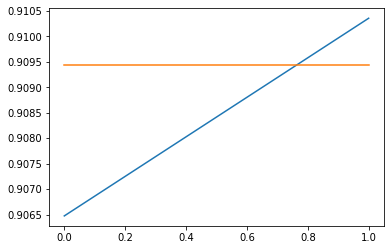

In [53]:
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.show()

---

---

# Testing Our Results

Methods we will test:
- Histogram
- Confusion Matrix

In [54]:
V, C = np.unique(y, return_counts=True)

for v, c in zip(V, C):
    print(v, " | ", c)

0.0  |  293864
1.0  |  20510
2.0  |  2326
3.0  |  946
4.0  |  674
5.0  |  692
6.0  |  538
7.0  |  458
8.0  |  371
9.0  |  279
10.0  |  245
11.0  |  208
12.0  |  174
13.0  |  159
14.0  |  149
15.0  |  149
16.0  |  103
17.0  |  115
18.0  |  73
19.0  |  84
20.0  |  62
21.0  |  61
22.0  |  56
23.0  |  54
24.0  |  43
25.0  |  44
26.0  |  35
27.0  |  33
28.0  |  37
29.0  |  21
30.0  |  25
31.0  |  20
32.0  |  23
33.0  |  18
34.0  |  17
35.0  |  20
36.0  |  12
37.0  |  9
38.0  |  10
39.0  |  14
40.0  |  7
41.0  |  12
42.0  |  8
43.0  |  10
44.0  |  5
45.0  |  4
46.0  |  4
47.0  |  7
48.0  |  9
49.0  |  4
50.0  |  5
51.0  |  6
52.0  |  3
53.0  |  2
54.0  |  4
55.0  |  4
56.0  |  3
57.0  |  1
58.0  |  2
60.0  |  4
61.0  |  1
62.0  |  5
63.0  |  2
64.0  |  1
65.0  |  1
66.0  |  2
67.0  |  2
68.0  |  1
69.0  |  1
72.0  |  1
73.0  |  1
74.0  |  1
76.0  |  2
77.0  |  2
78.0  |  1
81.0  |  2
82.0  |  1
84.0  |  1
85.0  |  1
90.0  |  1
99.0  |  1


(array([3.20658e+05, 1.45900e+03, 4.46000e+02, 1.68000e+02, 7.00000e+01,
        3.00000e+01, 2.00000e+01, 8.00000e+00, 5.00000e+00, 2.00000e+00]),
 array([ 0. ,  9.9, 19.8, 29.7, 39.6, 49.5, 59.4, 69.3, 79.2, 89.1, 99. ]),
 <a list of 10 Patch objects>)

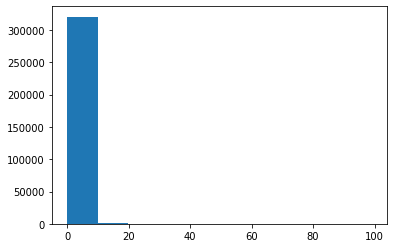

In [55]:
plt.hist(y)

What becomes clear from the histogram above is the class balance is _way_ off from anything remotely close to balanced.

## Confusion Matrix
A confusion matrix allws us to see the difference between the true labels `y_true` or (`y_test` in our example) and the predicted class labels `y_pred`.

In [56]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

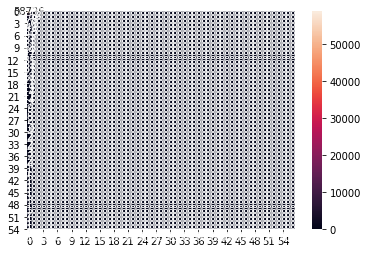

In [59]:
y_pred = dtc.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

heatmap = sns.heatmap(cm, annot=True, fmt="d")

plt.show(heatmap)

In [60]:
import plotly.graph_objects as go

fig = go.Figure(
    data=go.Heatmap(
        z=[[1, 20, 30],
          [20, 1, 60],
          [30, 60, 1]]))
fig.show()

In [103]:
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           #xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    #plt.figure(figsize=(20,20))
    fig.set_size_inches(11,11)
    return ax

/home/capcolabs/Stevens/Machine-Learning-Algorithms/venv/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning:

invalid value encountered in true_divide



Normalized confusion matrix
[[9.96786862e-01 2.29509869e-03 3.40014621e-04 8.50036552e-05
  6.80029241e-05 1.70007310e-05 8.50036552e-05 5.10021931e-05
  3.40014621e-05 1.70007310e-05 0.00000000e+00 0.00000000e+00
  0.00000000e+00 1.70007310e-05 1.70007310e-05 1.70007310e-05
  5.10021931e-05 0.00000000e+00 1.70007310e-05 0.00000000e+00
  0.00000000e+00 3.40014621e-05 3.40014621e-05 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40014621e-05
  0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [9.42233633e-01 4.05281496e-02 4.40124702e-03 2.75077939e-03
  5.50155877e-04 1.46708234e-03 1.65046763e-03 1.65046763e-03
  7.33541170e-04 1.65046763e-03 3.66770585e-04 7.33541170e-04
  1.83385292e-04 0.00000000e+00 1.83385292e-04 3.66770585e-04
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  1.83385292e-04 1.83385292e-04 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 1.83385292e-04 0.00000000e+00]
 [9.1333

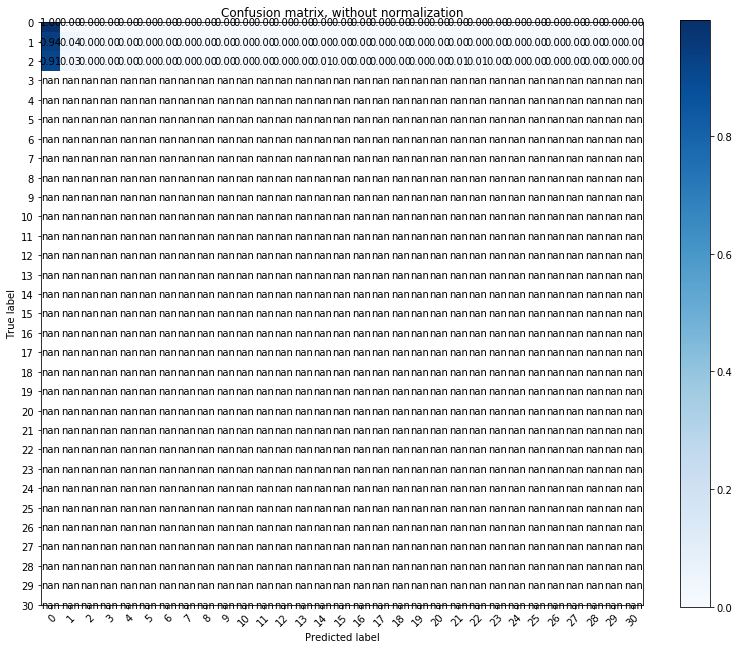

In [104]:
plot_confusion_matrix(
    y_test, y_pred, classes=class_names,
    normalize=True,
    title='Confusion matrix, without normalization')

# Creating New Label Data

Looking at the histogram above we see one issue, there are 293864 records with no delinquency, 20510 with 1 month max delinquence and then a near exponential decline from there. One method for us to handle this is to bin the delinquencies in various groups.

Our first binning attempt will be:
- D = 0
- D = 1-12
- D > 12

and determine the efficiency of our algorithms from there.

In [63]:
DEL_NOTNAN = acquisition_df["MAX_DELINQ"].notna()
df = acquisition_df[DEL_NOTNAN]
DEL_NOTNEG = df['MAX_DELINQ'] >= 0
df = df[DEL_NOTNEG]
OLTV = df['OLTV'].notna()
df = df[OLTV]
CS = df['CSCORE_B'].notna()
df = df[CS]

def mapper(row):
    delinq = row['MAX_DELINQ']
    if delinq > 12:
        return 2
    elif delinq > 0:
        return 1
    if delinq == -1:
        return -1
    else:
        return 0

df['Delinq.Bin'] = df.apply(mapper, axis=1)

credit_score  = np.array(df['CSCORE_B'])
loan_to_value = np.array(df['OLTV'])
max_delinq    = np.array(df['Delinq.Bin'])

X = np.array([credit_score, loan_to_value]).transpose()
y = np.array([max_delinq]).transpose()
print(X.shape)
print(y.shape)

Total = np.hstack([X, y])
print(Total.shape)
np.random.shuffle(Total)

X = Total[:, :2]
y = Total[:, 2:]

print(X.shape)
print(y.shape)

prop = 0.8
train_num = int(prop * len(Total))
print(f"Train Number: {train_num}")

X_train, X_test = X[:train_num], X[train_num:]
y_train, y_test = y[:train_num], y[train_num:]

print(f"X_Train: {X_train.shape}")
print(f"X_Test: {X_test.shape}")
print("=="*10)
print(f"y_Train: {y_train.shape}")
print(f"y_Test:  {y_test.shape}")

class_names = np.unique(y)

(322866, 2)
(322866, 1)
(322866, 3)
(322866, 2)
(322866, 1)
Train Number: 258292
X_Train: (258292, 2)
X_Test: (64574, 2)
y_Train: (258292, 1)
y_Test:  (64574, 1)


(array([293864.,      0.,      0.,      0.,      0.,  27421.,      0.,
             0.,      0.,   1581.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

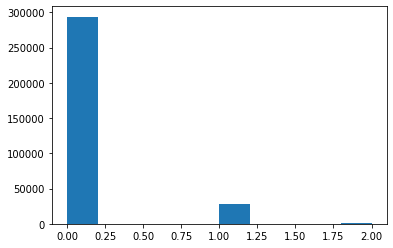

In [64]:
plt.hist(y)

## Creating Class Weighting

In [65]:
V, C = np.unique(y, return_counts=True)

class_weights = {}

for v, c in zip(V, C):
    prop = c / len(y)
    print(v, " | ", c)
    class_weights[v] = 1 - prop

0.0  |  293864
1.0  |  27421
2.0  |  1581


## Creating a Decision Tree with More Parameters

The decision tree classifier has a number of paramters during the creation of the model which will change the way the model was created.  The parameters are as follows (taken from https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier)

---

criterion : string, optional (default=”gini”)

    The function to measure the quality of a split. Supported criteria are “gini” for the Gini impurity and “entropy” for the information gain.
splitter : string, optional (default=”best”)

    The strategy used to choose the split at each node. Supported strategies are “best” to choose the best split and “random” to choose the best random split.
max_depth : int or None, optional (default=None)

    The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.
min_samples_split : int, float, optional (default=2)

    The minimum number of samples required to split an internal node:

        If int, then consider min_samples_split as the minimum number.
        If float, then min_samples_split is a fraction and ceil(min_samples_split * n_samples) are the minimum number of samples for each split.

    Changed in version 0.18: Added float values for fractions.
min_samples_leaf : int, float, optional (default=1)

    The minimum number of samples required to be at a leaf node. A split point at any depth will only be considered if it leaves at least min_samples_leaf training samples in each of the left and right branches. This may have the effect of smoothing the model, especially in regression.

        If int, then consider min_samples_leaf as the minimum number.
        If float, then min_samples_leaf is a fraction and ceil(min_samples_leaf * n_samples) are the minimum number of samples for each node.

    Changed in version 0.18: Added float values for fractions.
min_weight_fraction_leaf : float, optional (default=0.)

    The minimum weighted fraction of the sum total of weights (of all the input samples) required to be at a leaf node. Samples have equal weight when sample_weight is not provided.
max_features : int, float, string or None, optional (default=None)

    The number of features to consider when looking for the best split:

            If int, then consider max_features features at each split.
            If float, then max_features is a fraction and int(max_features * n_features) features are considered at each split.
            If “auto”, then max_features=sqrt(n_features).
            If “sqrt”, then max_features=sqrt(n_features).
            If “log2”, then max_features=log2(n_features).
            If None, then max_features=n_features.

    Note: the search for a split does not stop until at least one valid partition of the node samples is found, even if it requires to effectively inspect more than max_features features.
random_state : int, RandomState instance or None, optional (default=None)

    If int, random_state is the seed used by the random number generator; If RandomState instance, random_state is the random number generator; If None, the random number generator is the RandomState instance used by np.random.
max_leaf_nodes : int or None, optional (default=None)

    Grow a tree with max_leaf_nodes in best-first fashion. Best nodes are defined as relative reduction in impurity. If None then unlimited number of leaf nodes.
min_impurity_decrease : float, optional (default=0.)

    A node will be split if this split induces a decrease of the impurity greater than or equal to this value.

    The weighted impurity decrease equation is the following:

    N_t / N * (impurity - N_t_R / N_t * right_impurity
                        - N_t_L / N_t * left_impurity)

    where N is the total number of samples, N_t is the number of samples at the current node, N_t_L is the number of samples in the left child, and N_t_R is the number of samples in the right child.

    N, N_t, N_t_R and N_t_L all refer to the weighted sum, if sample_weight is passed.

    New in version 0.19.
min_impurity_split : float, (default=1e-7)

    Threshold for early stopping in tree growth. A node will split if its impurity is above the threshold, otherwise it is a leaf.

    Deprecated since version 0.19: min_impurity_split has been deprecated in favor of min_impurity_decrease in 0.19. The default value of min_impurity_split will change from 1e-7 to 0 in 0.23 and it will be removed in 0.25. Use min_impurity_decrease instead.
class_weight : dict, list of dicts, “balanced” or None, default=None

    Weights associated with classes in the form {class_label: weight}. If not given, all classes are supposed to have weight one. For multi-output problems, a list of dicts can be provided in the same order as the columns of y.

    Note that for multioutput (including multilabel) weights should be defined for each class of every column in its own dict. For example, for four-class multilabel classification weights should be [{0: 1, 1: 1}, {0: 1, 1: 5}, {0: 1, 1: 1}, {0: 1, 1: 1}] instead of [{1:1}, {2:5}, {3:1}, {4:1}].

    The “balanced” mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data as n_samples / (n_classes * np.bincount(y))

    For multi-output, the weights of each column of y will be multiplied.

    Note that these weights will be multiplied with sample_weight (passed through the fit method) if sample_weight is specified.
presort : bool, optional (default=False)

    Whether to presort the data to speed up the finding of best splits in fitting. For the default settings of a decision tree on large datasets, setting this to true may slow down the training process. When using either a smaller dataset or a restricted depth, this may speed up the training.
    
    
---


In [66]:
dtc = tree.DecisionTreeClassifier(
    max_depth=None,
    class_weight=class_weights
)
dtc.fit(X_train, y_train)
print(dtc.score(X_test, y_test))

0.678895530708954


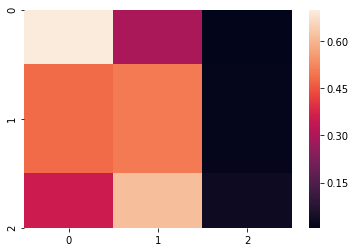

In [107]:
y_pred = dtc.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

heatmap = sns.heatmap(cm)

plt.show(heatmap)


Normalized confusion matrix
[[0.69827103 0.29599973 0.00572925]
 [0.48267009 0.50559325 0.01173666]
 [0.35333333 0.61666667 0.03      ]]


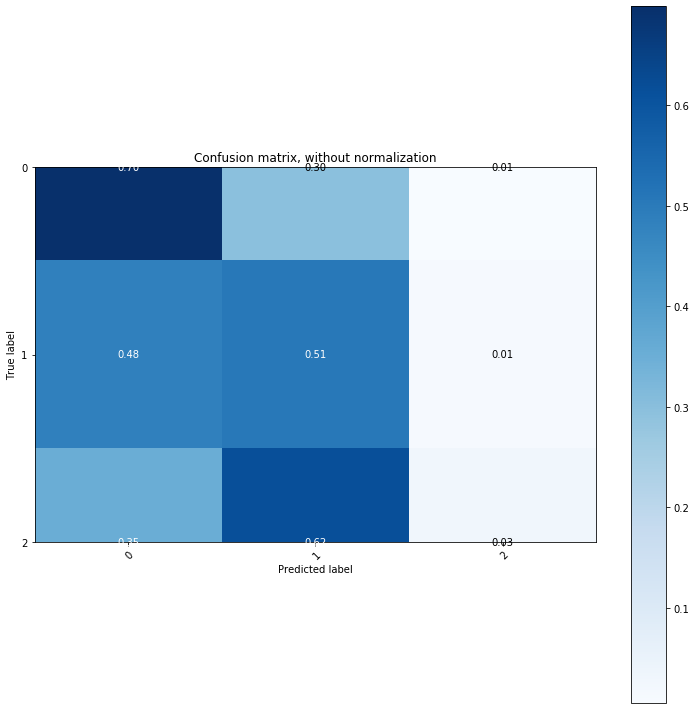

In [108]:

plot_confusion_matrix(
    y_test, y_pred, classes=class_names,
    normalize=True,
    title='Confusion matrix, without normalization')

In [109]:
rfc = RandomForestClassifier(
    n_estimators=50,
    class_weight=class_weights
)
rfc = rfc.fit(X_train, y_train)
print(rfc.score(X_test, y_test))

/home/capcolabs/Stevens/Machine-Learning-Algorithms/venv/lib/python3.7/site-packages/ipykernel_launcher.py:5: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



0.7293802459194103


Normalized confusion matrix
[[0.75933765 0.23850326 0.00215909]
 [0.54905557 0.44562626 0.00531817]
 [0.41333333 0.57333333 0.01333333]]


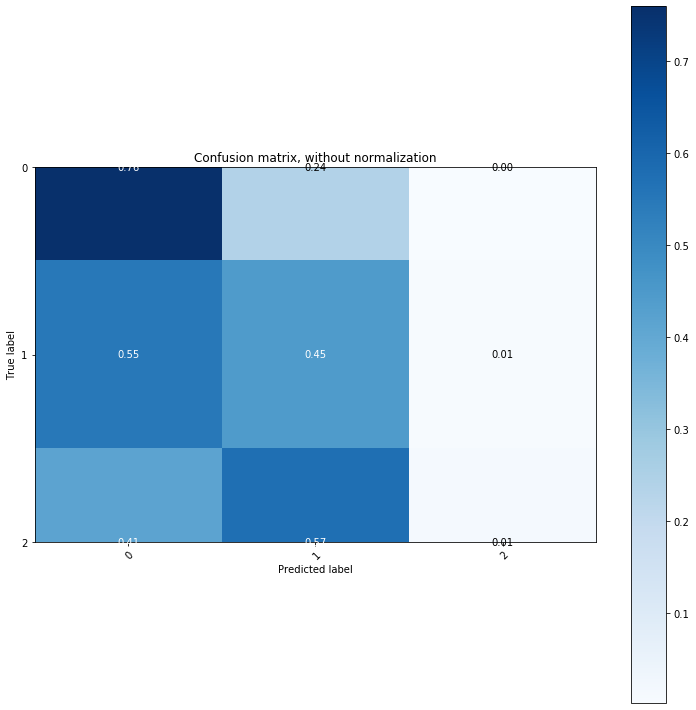

In [110]:
y_pred = rfc.predict(X_test)

plot_confusion_matrix(
    y_test, y_pred, classes=class_names,
    normalize=True,
    title='Confusion matrix, without normalization')


In [111]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_dataset  = tf.data.Dataset.from_tensor_slices((X_test, y_test))

BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = 100
V = np.unique(y)

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset  = test_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)

print(train_dataset)

<BatchDataset shapes: ((None, 2), (None, 1)), types: (tf.float64, tf.float64)>


In [112]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(32, input_shape=[2]),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(len(V), activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
)

In [113]:
history = model.fit(
    train_dataset, 
    validation_data=test_dataset, 
    class_weight=class_weights,
    epochs=1
)

4036/4036 [==============================] - 11s 3ms/step - loss: 0.5344 - sparse_categorical_accuracy: 0.8877 - val_loss: 0.0000e+00 - val_sparse_categorical_accuracy: 0.0000e+00


Normalized confusion matrix
[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]


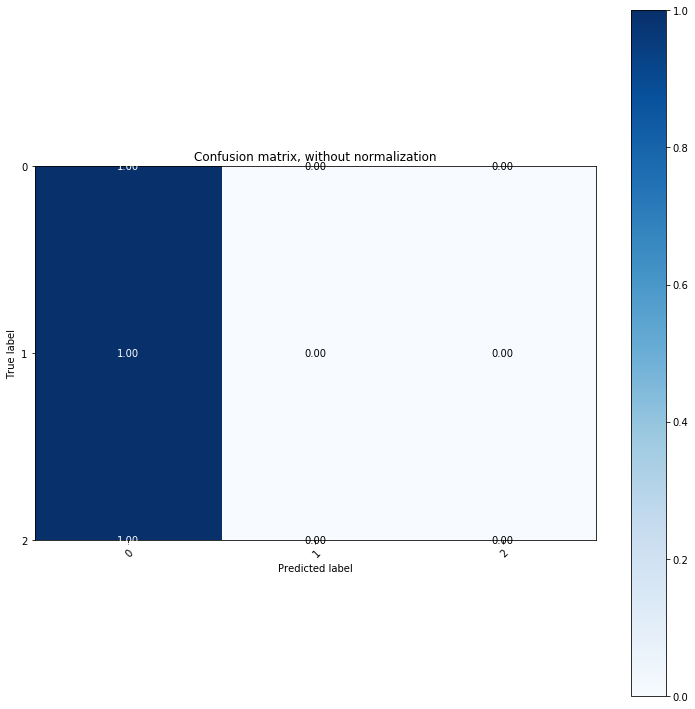

In [114]:
y_pred = model.predict_classes(X_test)

plot_confusion_matrix(
    y_test, y_pred, classes=class_names,
    normalize=True,
    title='Confusion matrix, without normalization')

# Conclusions

We see that given the data we have and the features we've chosen for the models are insufficient for the decision we are making.  We either need to:

- Expand the number of features we use for classification, or
- Modify the problem which we are working on to better be answered given our data.

### Expand Number of Features

The features we currently are using are:
- Credit Score
- Loan to Value

The features for Acquisition are:


`
AcquisitionColumnNames = (
    "LOAN_ID", "ORIG_CHN", "Seller.Name", 
    "ORIG_RT", "ORIG_AMT", "ORIG_TRM", "ORIG_DTE",
    "FRST_DTE", "OLTV", "OCLTV", "NUM_BO", 
    "DTI", "CSCORE_B", "FTHB_FLG", "PURPOSE", 
    "PROP_TYP", "NUM_UNIT", "OCC_STAT", "STATE", "ZIP_3", 
    "MI_PCT", "Product.Type", "CSCORE_C", "MI_TYPE", 
    "RELOCATION_FLG"
)
`


Potential features to add:
- Original Combined Loan to Value
- Debt-To-Income
- State
- Three Digit Zip Code
- Credit Score Co-Borrower

### Modify the Problem

We pursue this is in `05-Expanded_Data_Exporation`

